<a href="https://colab.research.google.com/github/Eeman1113/Mario-RL-AI/blob/main/MarioAI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setup Mario

In [1]:
!pip install gym_super_mario_bros==7.3.0 nes_py
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install -U colabgymrender
!sudo apt-get install xvfb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.


In [13]:
# Import the game
import gym_super_mario_bros
# Import the Joypad wrapper
from nes_py.wrappers import JoypadSpace
# Import the SIMPLIFIED controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from colabgymrender.recorder import Recorder

In [2]:
%%bash

# install required system dependencies
apt-get install -y xvfb x11-utils

# install required python dependencies (might need to install additional gym extras depending)
pip install gym[box2d]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*

Reading package lists...
Building dependency tree...
Reading state information...
x11-utils is already the newest version (7.7+3build1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for gym: filename=gym-0.17.3-py3-none-any.whl size=1654653 sha256=b0cecc3c66dceb2cfef1f6a1ed71c1056d60d10dd174dc11a67ce1d87adbf237
  Stored in directory: /root/.cache/pip/wheels/d1/81/4b/dd9c029691022cb957398d1f015e66b75e37637dda61abdf58
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.21.0
    Uninstalling gym-0.21.0:
      Successfully uninstalled gym-0.21.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
stable-baselines3 1.5.0 requires gym==0.21, but you have gym 0.17.3 which is incompatible.


In [3]:
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""


def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")


def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

In [24]:
# Setup game
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env=wrap_env(gym_super_mario_bros.make('SuperMarioBros-v0'))
env = JoypadSpace(env, SIMPLE_MOVEMENT)

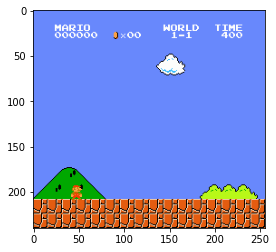

In [8]:
# Create a flag - restart or not
done = True
img = plt.imshow(env.render('rgb_array'))
# Loop through each frame in the game
for step in range(100000): 
    # Start the game to begin with 
    if done: 
        # Start the gamee
        env.reset()
    # Do random actions
    state, reward, done, info = env.step(env.action_space.sample())
    # Show the game on the screen
    env.render()
    
# Close the game
env.close()
show_video()

# 2. Preprocess Environment

In [6]:
# Install pytorch
!pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html


In [8]:
# Install stable baselines for RL stuff
!pip install stable-baselines3[extra]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
# Import Frame Stacker Wrapper and GrayScaling Wrapper
from gym.wrappers import GrayScaleObservation
# Import Vectorization Wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
# Import Matplotlib to show the impact of frame stacking
from matplotlib import pyplot as plt

In [14]:
# 1. Create the base environment
env = gym_super_mario_bros.make('SuperMarioBros-v0')
env=wrap_env(gym_super_mario_bros.make('SuperMarioBros-v0'))
# 2. Simplify the controls 
env = JoypadSpace(env, SIMPLE_MOVEMENT)
# 3. Grayscale
env = GrayScaleObservation(env, keep_dim=True)
# 4. Wrap inside the Dummy Environment
env = DummyVecEnv([lambda: env])
# 5. Stack the frames
env = VecFrameStack(env, 4, channels_order='last')

In [15]:
state = env.reset()

In [16]:
state, reward, done, info = env.step([5])

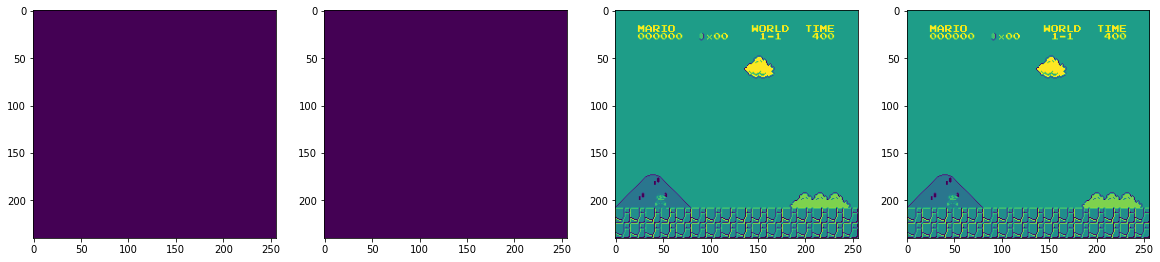

In [17]:
plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

# 3. Train the RL Model

In [18]:
# Import os for file path management
import os 
# Import PPO for algos
from stable_baselines3 import PPO
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

In [19]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [26]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [28]:
# Setup model saving callback
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [29]:
# This is the AI model started
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, 
            n_steps=512) 

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [ ]:
# Train the AI model, this is where the AI model starts to learn
model.learn(total_timesteps=1000000, callback=callback)

Streaming output truncated to the last 5000 lines.
|    value_loss           | 387          |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.2e+03      |
|    ep_rew_mean          | 1.86e+03     |
| time/                   |              |
|    fps                  | 84           |
|    iterations           | 1174         |
|    time_elapsed         | 7154         |
|    total_timesteps      | 601088       |
| train/                  |              |
|    approx_kl            | 0.0001000826 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.164       |
|    explained_variance   | 0.776        |
|    learning_rate        | 1e-06        |
|    loss                 | 219          |
|    n_updates            | 11730        |
|    policy_gradient_loss | -0.000123    |
|    value_loss           | 314          |
---

In [ ]:
model.save('thisisatestmodel')

# 4. Test it Out

In [ ]:
# Load model
model = PPO.load('./train/best_model_1000000')

In [ ]:
state = env.reset()

In [ ]:
# Start the game 
state = env.reset()
# Loop through the game
while True: 
    
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()